# Vizualizing data and building BQML models in a Jupyter notebook

[BigQuery](https://cloud.google.com/bigquery/docs/) is a petabyte-scale analytics data warehouse that you can use to run SQL queries over vast amounts of data in near realtime.

Data visualization tools can help you make sense of your BigQuery data and help you analyze the data interactively. You can use visualization tools to help you identify trends, respond to them, and make predictions using your data. In this tutorial, you use the BigQuery Python client library and pandas in a Jupyter notebook to visualize data in the BigQuery natality sample table.

## Using Jupyter magics to query BigQuery data

The BigQuery Python client library provides a magic command that allows you to run queries with minimal code.

The BigQuery client library provides a cell magic, `%%bigquery`. The `%%bigquery` magic runs a SQL query and returns the results as a pandas `DataFrame`. The following cell executes a query of the BigQuery natality public dataset and returns the total births by year.

In [111]:
%%bigquery
SELECT
    count(*) as Total_Records
FROM `bigquery-public-data.samples.natality`

,Total_Records
0,137826763


In [112]:
%%bigquery
SELECT
    source_year AS year,
    COUNT(is_male) AS birth_count
FROM `bigquery-public-data.samples.natality`
GROUP BY year
ORDER BY year DESC
LIMIT 15

,year,birth_count
0,2008,4255156
1,2007,4324008
2,2006,4273225
3,2005,4145619
4,2004,4118907
5,2003,4096092
6,2002,4027376
7,2001,4031531
8,2000,4063823
9,1999,3963465


The following command runs the same query, but this time the results are saved to a variable. The variable name, `total_births`, is given as an argument to the `%%bigquery`. The results can then be used for further analysis and visualization.

In [113]:
%%bigquery total_births
SELECT
    source_year AS year,
    COUNT(is_male) AS birth_count
FROM `bigquery-public-data.samples.natality`
GROUP BY year
ORDER BY year DESC
LIMIT 15

The next cell uses the pandas `DataFrame.plot` method to visualize the query results as a bar chart. See the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/visualization.html) to learn more about data visualization with pandas.

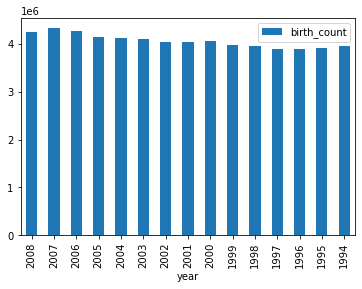

In [114]:
total_births.plot(kind='bar', x='year', y='birth_count');

Run the following query to retrieve the number of births by weekday. Because the `wday` (weekday) field allows null values, the query excludes records where wday is null.

In [115]:
%%bigquery births_by_weekday
SELECT
    wday,
    SUM(CASE WHEN is_male THEN 1 ELSE 0 END) AS male_births,
    SUM(CASE WHEN is_male THEN 0 ELSE 1 END) AS female_births
FROM `bigquery-public-data.samples.natality`
WHERE wday IS NOT NULL
GROUP BY wday
ORDER BY wday ASC

Visualize the query results using a line chart.

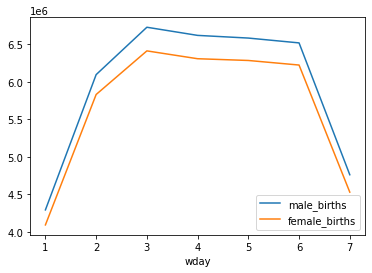

In [116]:
births_by_weekday.plot(x='wday');

## Using Python to query BigQuery data

Magic commands allow you to use minimal syntax to interact with BigQuery. Behind the scenes, `%%bigquery` uses the BigQuery Python client library to run the given query, convert the results to a pandas `Dataframe`, optionally save the results to a variable, and finally display the results. Using the BigQuery Python client library directly instead of through magic commands gives you more control over your queries and allows for more complex configurations. The library's integrations with pandas enable you to combine the power of declarative SQL with imperative code (Python) to perform interesting data analysis, visualization, and transformation tasks.

To use the BigQuery Python client library, start by importing the library and initializing a client. The BigQuery client is used to send and receive messages from the BigQuery API.

In [27]:
from google.cloud import bigquery

client = bigquery.Client()

Use the [`Client.query`](https://googleapis.github.io/google-cloud-python/latest/bigquery/generated/google.cloud.bigquery.client.Client.html#google.cloud.bigquery.client.Client.query) method to run a query. Execute the following cell to run a query to retrieve the annual count of plural births by plurality (2 for twins, 3 for triplets, etc.).

In [119]:
sql = """
SELECT
    plurality,
    COUNT(1) AS count,
    year
FROM
    `bigquery-public-data.samples.natality`
WHERE
    NOT IS_NAN(plurality) AND plurality > 1
GROUP BY
    plurality, year
ORDER BY
    count DESC
"""
df = client.query(sql).to_dataframe()
df.head()

,plurality,count,year
0,2,139209,2007
1,2,138866,2008
2,2,137239,2006
3,2,133285,2005
4,2,132344,2004


To chart the query results in your `DataFrame`, run the following cell to pivot the data and create a stacked bar chart of the count of plural births over time.

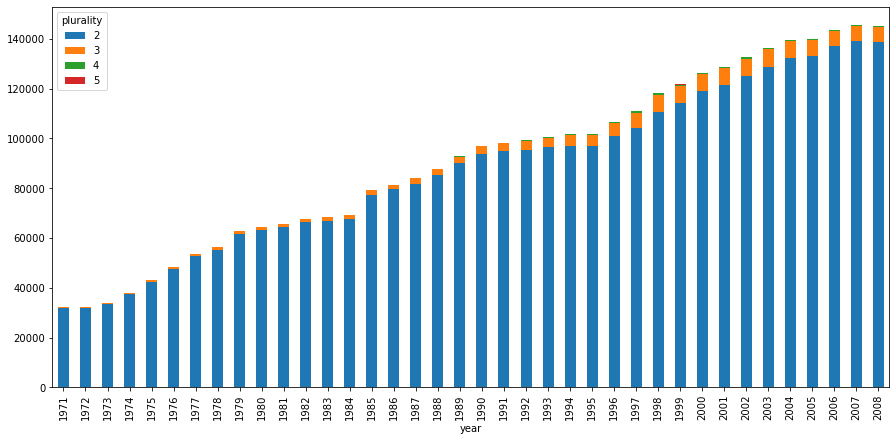

In [120]:
pivot_table = df.pivot(index='year', columns='plurality', values='count')
pivot_table.plot(kind='bar', stacked=True, figsize=(15, 7));

Run the following query to retrieve the count of births by the number of gestation weeks.

In [30]:
sql = """
SELECT
    gestation_weeks,
    COUNT(1) AS count
FROM
    `bigquery-public-data.samples.natality`
WHERE
    NOT IS_NAN(gestation_weeks) AND gestation_weeks <> 99
GROUP BY
    gestation_weeks
ORDER BY
    gestation_weeks
"""
df = client.query(sql).to_dataframe()

Finally, chart the query results in your `DataFrame`.

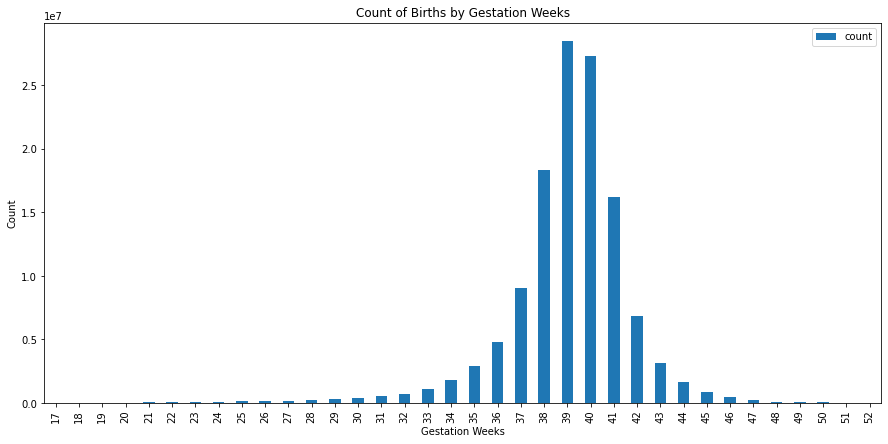

In [31]:
ax = df.plot(kind='bar', x='gestation_weeks', y='count', figsize=(15,7))
ax.set_title('Count of Births by Gestation Weeks')
ax.set_xlabel('Gestation Weeks')
ax.set_ylabel('Count');

### `CREATE MODEL` using `linear_reg`

Next, let's create a linear regression model on the public natality
dataset available in BigQuery. This model predicts the birth weight of a 
child based on the baby's gender, the length of the pregnancy, 
and demographic information about the mother 

The standard SQL query uses a `CREATE MODEL` statement to create 
and train the model. Standard SQL is the default query syntax 
for the BigQuery python client library.

To run the `CREATE MODEL` query to create and train your model:

In [121]:
%%bigquery
CREATE or REPLACE MODEL `bqml.natality_lin_reg`
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['weight_pounds']) AS
SELECT
  weight_pounds,
  is_male,
  gestation_weeks,
  mother_age,
  CAST(mother_race AS string) AS mother_race
FROM
  `bigquery-public-data.samples.natality`
WHERE
  weight_pounds IS NOT NULL
  AND RAND() < 0.001

""


### `CREATE MODEL` using `DNN`

We can also create a DNN regression model simply by replacing the model type with `dnn_regressor`

### Using ```TRANSFORM```
In the code below, we have taken advantage of some built-in functions within BigQuery to some data pre-processing.  Specifically, the ```TRANSFORM``` clause lets you specify preprocessing options during model creation. The preprocessing is automatically applied during the prediction and evaluation phases of machine learning.

We've also used some preprocessing helper functions - ```ML.QUANTILE_BUCKETIZE``` and ```ML.FEATURE_CROSS``` preprocessing functions to place mother's age into five buckets and create a new feature from a combination of gender and mother's reported race

In [127]:
%%bigquery
CREATE or REPLACE MODEL `bqml.natality_dnn`
TRANSFORM(weight_pounds,
    is_male,
    gestation_weeks,
    ML.QUANTILE_BUCKETIZE(mother_age,
      5) OVER() AS bucketized_mother_age,
    CAST(mother_race AS string) AS mother_race,
    ML.FEATURE_CROSS(STRUCT(is_male,
        CAST(mother_race AS STRING) AS mother_race)) is_male_mother_race)
OPTIONS
  (model_type='dnn_regressor',
    input_label_cols=['weight_pounds']) AS
SELECT
  *
FROM
  `bigquery-public-data.samples.natality`
WHERE
  weight_pounds IS NOT NULL
  AND RAND() < 0.01

""


Let's look at the training information for both models:

In [62]:
%%bigquery
SELECT
  'Lin Reg' as model_type,  *
FROM
  ML.TRAINING_INFO(MODEL `bqml.natality_lin_reg`)
Union all
SELECT
  'DNN' as MODEL_TYPE,*
FROM
  ML.TRAINING_INFO(MODEL `bqml.natality_dnn`)


,model_type,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,Lin Reg,0,0,1.675326,1.659983,NaN,13917
1,DNN,0,1,1.171161,1.181610,0.000965,156367
2,DNN,0,0,1.224593,1.185284,0.000858,140056


We can also call ```ML.EVALUATE``` to understand the models performance against the entire dataset.  If no query is passed in, then by default, ```ML.EVALUATE```
will report evaluation metrics from the training and eval datasets that were partitioned from the input data during model training.

In [63]:
%%bigquery
SELECT
 'Lin Reg' as model_type,* 
FROM
 ML.EVALUATE(MODEL `bqml.natality_lin_reg`,
            (
    SELECT
      weight_pounds,
      is_male,
      gestation_weeks,
      mother_age,
      CAST(mother_race AS STRING) AS mother_race
    FROM
      `bigquery-public-data.samples.natality`
    WHERE
      weight_pounds IS NOT NULL))
UNION ALL
SELECT
 'DNN' as model_type,*
FROM
 ML.EVALUATE(MODEL `bqml.natality_dnn`,(
    SELECT
      *
    FROM
      `bigquery-public-data.samples.natality`
    WHERE
      weight_pounds IS NOT NULL))



,model_type,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,Lin Reg,0.956317,1.675516,0.034258,0.737949,0.046574,0.046577
1,DNN,1.255202,6.941695,0.021053,0.708529,-2.950062,-2.837204


### Using ```ML.PREDICT``` to generate predictions

In [122]:
%%bigquery
SELECT
  predicted_weight_pounds, weight_pounds as actual_weight_pounds
FROM
  ML.PREDICT(MODEL `bqml.natality_dnn`,
    (
    SELECT
      *
    FROM
      `bigquery-public-data.samples.natality`
    WHERE
      state = "WY" limit 10))

,predicted_weight_pounds,actual_weight_pounds
0,7.759904,7.561856
1,7.999978,8.126239
2,7.812028,8.062305
3,7.546218,7.251004
4,7.702193,5.687926
5,7.750594,9.186662
6,7.449198,7.625790
7,8.064459,6.437498
8,8.064459,7.687519
9,7.812028,8.562754


### Exporting the model to Cloud Storage for real-time prediction serving
When using the ```CREATE MODEL``` statement in BQ, you create a model that is deployed within the bigquery engine which can be used to generate on-demand predictions via a SQL interface.  If you'd like to use that model to generate predictions for real-time use cases, simply export the model from BQ and import the model into the AI Platform.

Let's export the model to Cloud Storage:

In [57]:
!bq extract -m bqml.natality_lin_reg gs://stryker_bqml/natality_lin_reg


Waiting on bqjob_r730a88b048c23ff4_00000175b4f7c483_1 ... (22s) Current status: DONE   


Now, let's create a model and a model version in AI Platform

In [68]:
!gcloud ai-platform models create natality --regions us-central1

Using endpoint [https://ml.googleapis.com/]
Created ml engine model [projects/swarm-nc-stryker/models/natality].


In [71]:
%%bash

gcloud ai-platform versions create lin_reg_v1 \
  --model natality \
  --runtime-version 2.1 \
  --framework tensorflow \
  --staging-bucket gs://strykerbq_ml \
  --origin gs://stryker_bqml/natality_lin_reg

Using endpoint [https://ml.googleapis.com/]
Creating version (this might take a few minutes)......
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................done.


In [123]:
%%bigquery df_record
SELECT
      is_male,
      gestation_weeks,
      mother_age,
      CAST(mother_race AS STRING) AS mother_race
    FROM
      `bigquery-public-data.samples.natality`
    WHERE
      weight_pounds IS NOT NULL
      AND RAND() < 0.05
      limit 1


In [124]:
input_str = df_record.to_json(orient='records', lines=True)
print(input_str)

online_input = open('online_input.json', 'w')
online_input.write("%s\n" % input_str)
online_input.close()


{"is_male":false,"gestation_weeks":40,"mother_age":40,"mother_race":"4"}


In [126]:
MODEL_NAME="natality"
VERSION_NAME="lin_reg_v1"
INSTANCES = "online_input.json"
!gcloud ai-platform predict --model $MODEL_NAME --version $VERSION_NAME --json-instances=$INSTANCES


Using endpoint [https://ml.googleapis.com/]
PREDICTED_WEIGHT_POUNDS
[7.2376026642741635]
